In [1]:
import sys
sys.path.append('../')

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision.datasets import CelebA
from torchvision import transforms
from tqdm import tqdm
import torchvision.transforms.functional as TF
import math

/opt/miniconda3/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Dataloader (you can mess with batch size)
BATCH_SIZE = 128

# How many runs through the data should we do?
NO_EPOCHS = 200

# How time steps for scheduler?
TIME_STEPS = 300

# Noise Variance
BETAS = torch.linspace(0.0001, 0.02, TIME_STEPS)

# Transformations
transform_pipelines = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),  # (3,W,H)
        transforms.Lambda(lambda t: (t * 2) - 1),
    ]
)


undo_transform_pipelines = transforms.Compose(
    [
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW to HWC
        transforms.Lambda(
            lambda t: (t * 255.0).numpy().astype(np.uint8)
        ),  # Scale data between [0.,255.]
    ]
)

In [5]:
def load_data(dataset_name="CIFAR10", batch_size=16, transform=None):
    dataset_mapping = {
        "CIFAR10": {"class": CIFAR10, "root": "../data"},
        "CelebA": {"class": CelebA, "root": "../data"},
    }

    dataset_info = dataset_mapping[dataset_name]
    dataset_class = dataset_info["class"]
    dataset_root = dataset_info["root"]

    dataset = dataset_class(root=dataset_root, download=True, transform=transform)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )

    images, labels = next(iter(dataloader))

    return images, labels

In [6]:
def noise_scheduler(
    x_0: torch.tensor, t: torch.tensor, betas: torch.tensor, device: str
):
    noise = torch.randn(size=x_0.shape)

    alpha_hats = torch.cumprod(1 - betas, axis=0)

    selected_alpha_hats = alpha_hats[t]
    selected_alpha_hats = selected_alpha_hats.reshape(shape=(t.shape[0], 1, 1, 1))

    mean = torch.sqrt(selected_alpha_hats) * x_0
    variance = torch.sqrt(1.0 - selected_alpha_hats) * noise

    x_ts = mean + variance

    return x_ts.to(device), noise.to(device)

In [7]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, embed_time_dims):
        super().__init__()

        self.time_mlp = nn.Sequential(
            nn.Linear(embed_time_dims, out_channels),
            nn.ReLU(inplace=True),
        )

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x, t):
        h = self.conv1(x)
        time_emb = self.time_mlp(t)
        h = h + time_emb[..., None, None]
        h = self.conv2(h)

        return h


class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.half_dim = dim // 2

    def forward(self, t):
        device = t.device

        embeddings = (
            torch.arange(self.half_dim, device=device)
            * math.log(10000)
            / (self.half_dim - 1)
        )
        embeddings = torch.exp(-embeddings)

        embeddings = t[:, None] * embeddings[None, :]

        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        return embeddings


class SimpleUnet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        features = [64, 128, 256, 512]
        time_emb_dim = 32

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Time embedding
        self.time_mlp = nn.Sequential(
            TimeEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
        )

        self.downs = nn.ModuleList()
        for feature in features:
            self.downs.append(
                Block(in_channels, feature, time_emb_dim),
            )
            in_channels = feature

        # Upsample
        self.ups = nn.ModuleList()
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, 2, 2))
            self.ups.append(Block(feature * 2, feature, time_emb_dim))

        self.bottleneck = Block(features[-1], features[-1] * 2, time_emb_dim)
        self.final_conv = nn.Conv2d(features[0], out_channels, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)

        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
            x = self.pool(x)

        x = self.bottleneck(x, t)

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = self.ups[i + 1](x, t)

        return self.final_conv(x)

In [8]:
# Google-Drive Error: Follow link to manually download CelebA dataset https://github.com/pytorch/vision/issues/2262#issuecomment-1235752527
# images, labels = load_data(dataset_name='CelebA', batch_size=8, transform=transform_pipelines)
images, labels = load_data(
    dataset_name="CIFAR10", batch_size=8, transform=transform_pipelines
)

100%|██████████| 170498071/170498071 [00:23<00:00, 7306676.69it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


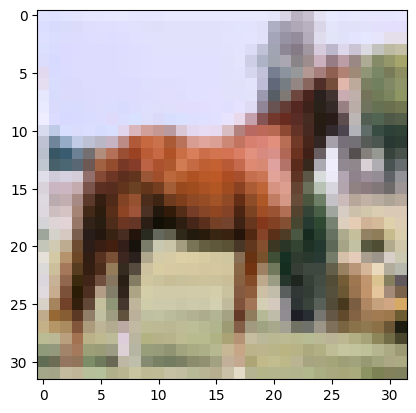

In [9]:
plt.imshow(undo_transform_pipelines(images[0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


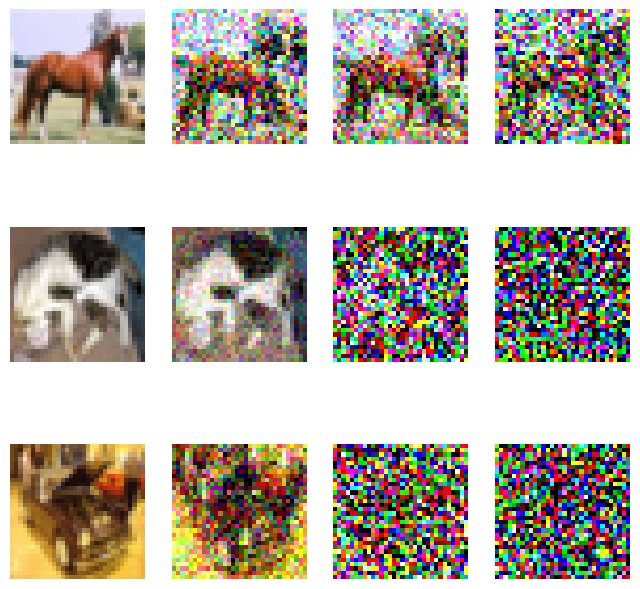

In [10]:
def display_noisy_images(img, nrow=3):
    _, ax = plt.subplots(nrow, 4, figsize=(8, 8))

    for j in range(nrow):
        images_to_display = img[j].permute(1, 2, 0)
        images_to_display = images_to_display / 2 + 0.5  # unnormalize

        # Display the original image without noise
        ax[j, 0].imshow(images_to_display)
        ax[j, 0].axis("off")

        # List to store tuples (noisy_image, noise_level)
        noisy_images = []

        for i in range(1, 4):
            t = torch.randint(0, TIME_STEPS, (BATCH_SIZE,)).long()
            noisy_image, _ = noise_scheduler(
                images_to_display, t=t, betas=BETAS, device=device
            )

            # Keep track of respective noise level
            noise_level = BETAS[t[0]].item()
            noisy_images.append((noisy_image[0], noise_level))

        # Sort the list based on noise level
        noisy_images.sort(key=lambda x: x[1])

        # Display the noisy images
        for i, (noisy_image, noise_level) in enumerate(noisy_images, start=1):
            ax[j, i].imshow(torch.clamp(noisy_image.cpu(), -1.0, 1.0))
            ax[j, i].axis("off")

    plt.show()


display_noisy_images(images, nrow=3)

In [11]:
# SINGLE IMAGE TRAINING
img = images[0]

# Create the network
model = SimpleUnet()
model.to(device)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in tqdm(range(NO_EPOCHS)):
    img_batch = torch.stack([img] * BATCH_SIZE)
    t = torch.randint(0, TIME_STEPS, (BATCH_SIZE,)).long()

    img_batch_noisy, noise_batch = noise_scheduler(
        x_0=img_batch, t=t, betas=BETAS, device=device
    )

    t = t.to(device)

    predicted_noise_batch = model(img_batch_noisy, t)

    loss = loss_fn(predicted_noise_batch, noise_batch)
    batch_loss = loss.item()

    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(batch_loss)

    # Print our the average of the loss values for this epoch:
    if (epoch + 1) % 50 == 0:
        print(f"Finished epoch {epoch}. Average loss for this epoch: {batch_loss:05f}")


# View the loss curve
plt.plot(losses)
plt.ylim(0, 1)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Over Epochs")

# # Save the plot to the specified location
# save_location = "./data/output/training_loss_plot.png"
# plt.savefig(save_location)

# Show the plot
plt.show()

 19%|█▉        | 38/200 [02:42<11:31,  4.27s/it]


KeyboardInterrupt: 

<Figure size 3000x3000 with 0 Axes>

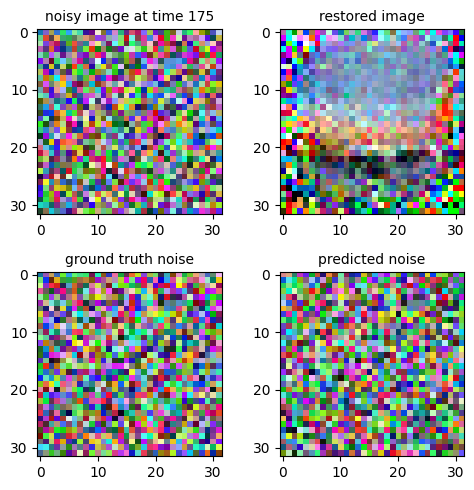

In [ ]:
t = torch.randint(0, TIME_STEPS, (1,)).long()
img_noisy, noise = noise_scheduler(x_0=img, t=t, betas=BETAS, device=device)

with torch.no_grad():
    t = t.to(device)
    predicted_noise = model(img_noisy[0].unsqueeze(0), t)

    predicted_noise = predicted_noise.cpu().squeeze()
    noise = noise.cpu()

    img_n = img_noisy[0].cpu()

    restored_img = img_n - predicted_noise
    restored_img = torch.clamp(restored_img, -1.0, 1.0).squeeze()

    plt.figure(figsize=(30, 30))
    f, ax = plt.subplots(2, 2, figsize=(5, 5))

    ax[0, 0].imshow(undo_transform_pipelines(img_n))
    ax[0, 0].set_title(f"noisy image at time {t[0]}", fontsize=10)
    ax[0, 1].imshow(undo_transform_pipelines(restored_img))
    ax[0, 1].set_title(f"restored image", fontsize=10)

    ax[1, 0].imshow(undo_transform_pipelines(noise))
    ax[1, 0].set_title(f"ground truth noise", fontsize=10)
    ax[1, 1].imshow(undo_transform_pipelines(predicted_noise))
    ax[1, 1].set_title(f"predicted noise", fontsize=10)

    f.tight_layout()
    plt.show()

In [ ]:
dataset = CIFAR10(download=True, transform=transform_pipelines, root="./data")

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

one_class_data = []

count = 0
while count < BATCH_SIZE:
    images, labels = next(iter(dataloader))
    if labels[0] == 1:
        count += 1
        one_class_data.append(images[0])

one_class_data = torch.stack(one_class_data)

Files already downloaded and verified


In [ ]:
num_steps = TIME_STEPS
betas = BETAS
alphas = 1.0 - betas
alpha_hats = torch.cumprod(alphas, axis=0)

In [ ]:
def reverse(
    noised_images: torch.Tensor, predicted_noise: torch.Tensor, t: torch.Tensor
) -> torch.Tensor:
    """
    Reverse the diffusion process to reconstruct the original images.

    Parameters:
    - noised_images: Tensor of noised images after the diffusion process.
    - noise: Tensor of noise applied during the diffusion process.
    - t: Tensor representing the time step for each image.

    Returns:
    Reconstructed images.
    """
    # Evaluate the gamma function at the given time step for each image
    N = noised_images.shape[0]
    gamma_t = alpha_hats[t].reshape(shape=[N, 1, 1, 1])

    # Reverse the diffusion process
    reconstructed_images = (
        noised_images - torch.sqrt(1.0 - gamma_t) * predicted_noise
    ) / torch.sqrt(gamma_t)
    reconstructed_images = torch.clamp(reconstructed_images, -1.0, 1.0)
    return reconstructed_images

 25%|██▌       | 50/200 [03:14<09:37,  3.85s/it]

Epoch [50/200], Loss: 0.1358


 50%|█████     | 100/200 [06:27<06:27,  3.88s/it]

Epoch [100/200], Loss: 0.0847


 75%|███████▌  | 150/200 [09:42<03:12,  3.85s/it]

Epoch [150/200], Loss: 0.0637


100%|██████████| 200/200 [12:57<00:00,  3.89s/it]

Epoch [200/200], Loss: 0.0661


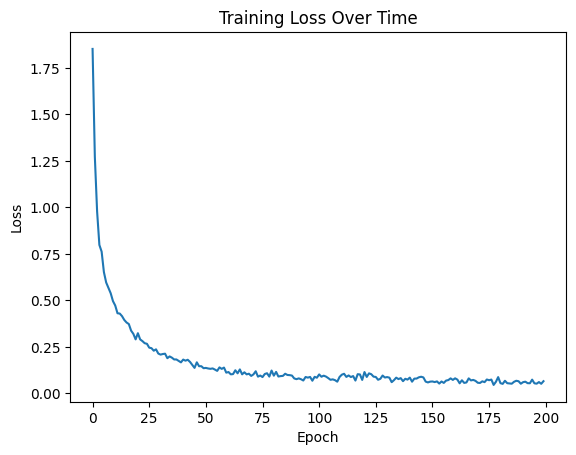

In [ ]:
def train_ddpm_single_image(model, single_img, epochs, time_steps, betas, device):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    losses = []

    for epoch in tqdm(range(epochs)):
        epoch_loss = 0.0
        t = torch.randint(0, time_steps, (BATCH_SIZE,)).long().to(device)

        img_batch = single_img.repeat(BATCH_SIZE, 1, 1, 1).to(device)
        img_batch_noisy, noise_batch = noise_scheduler(img_batch, t, betas, device)

        predicted_noise_batch = model(img_batch_noisy, t)
        reconstructed_imgs = reverse(img_batch_noisy, predicted_noise_batch, t)

        loss = F.mse_loss(reconstructed_imgs, img_batch) + F.mse_loss(
            predicted_noise_batch, noise_batch
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")
        losses.append(epoch_loss)

    return losses


# Initialize model and train
model = SimpleUnet().to(device)

# Load single image
single_img = images[0]

# Train the model
losses = train_ddpm_single_image(
    model, single_img, NO_EPOCHS, TIME_STEPS, BETAS, device
)

# Plotting the training loss
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.show()

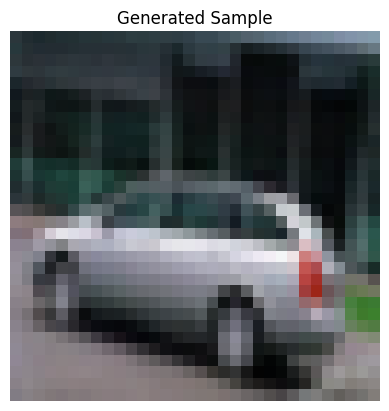

In [ ]:
def generate_sample(model, num_steps=TIME_STEPS, betas=BETAS):
    model.eval()
    with torch.no_grad():
        # Start from random noise
        sample = torch.randn((1, 3, 32, 32), device=device)
        for t in reversed(range(num_steps)):
            t_tensor = torch.full((1,), t, dtype=torch.long, device=device)
            predicted_noise = model(sample, t_tensor)
            sample = reverse(sample, predicted_noise, t_tensor)
        return sample


generated_image = generate_sample(model)
plt.imshow(undo_transform_pipelines(generated_image.squeeze()))
plt.title("Generated Sample")
plt.axis("off")
plt.show()

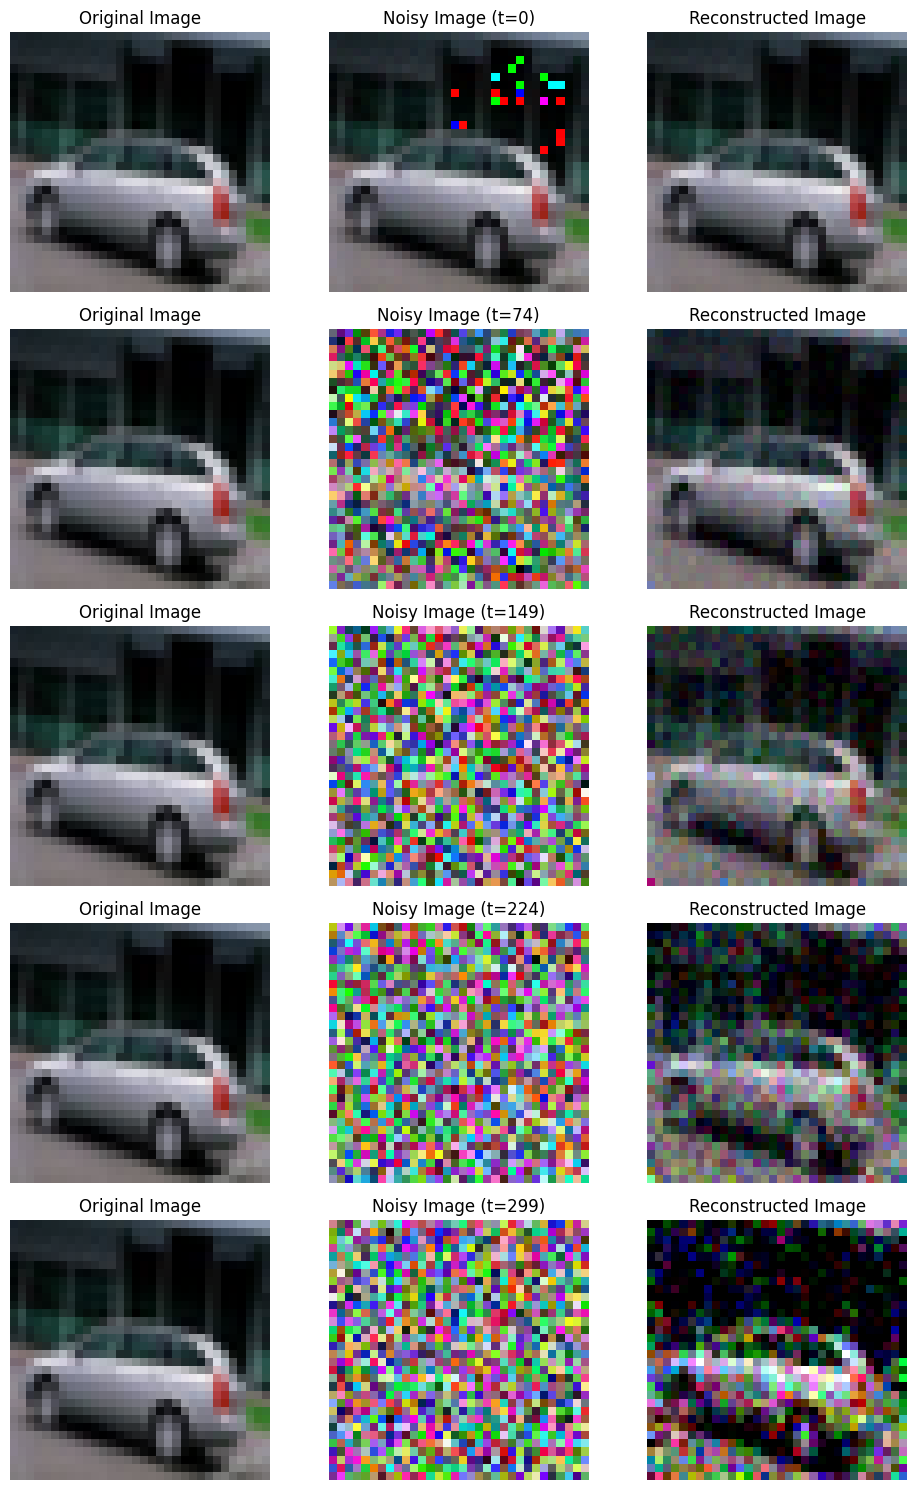

In [ ]:
def visualize_reconstruction(model, single_img, time_steps, betas, num_examples=5):
    model.eval()
    _, axes = plt.subplots(num_examples, 3, figsize=(10, num_examples * 3))

    selected_timesteps = torch.linspace(0, time_steps - 1, steps=num_examples).long()

    with torch.no_grad():
        for i, t in enumerate(selected_timesteps):
            # t = torch.randint(0, time_steps, (1,)).long().to(device)
            img_noisy, _ = noise_scheduler(
                single_img.unsqueeze(0).to(device), t.unsqueeze(0), betas, device
            )
            predicted_noise = model(img_noisy, t.unsqueeze(0))
            reconstructed_img = reverse(img_noisy, predicted_noise, t.unsqueeze(0))

            axes[i, 0].imshow(undo_transform_pipelines(single_img))
            axes[i, 0].set_title("Original Image")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(undo_transform_pipelines(img_noisy.squeeze()))
            axes[i, 1].set_title(f"Noisy Image (t={t.item()})")
            axes[i, 1].axis("off")

            axes[i, 2].imshow(undo_transform_pipelines(reconstructed_img.squeeze()))
            axes[i, 2].set_title("Reconstructed Image")
            axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()


# Visualize reconstructions
visualize_reconstruction(model, single_img, TIME_STEPS, BETAS)